# GO Terms and Gene Mapping Analysis

This notebook uses goatools to obtain all GO terms and their associated genes, creating a comprehensive mapping for similarity analysis.

## Overview
- **Load GO Ontology**: Load GO terms from OBO file
- **Load Gene Associations**: Load gene-to-GO term mappings from GAF file
- **Create Comprehensive Mapping**: Generate mapping of GO terms to genes
- **Export Results**: Save the mapping for further analysis

## Input Requirements
- GO OBO file (go-basic.obo)
- Gene association file (go_style_gaf.tsv)

## Output
- Dictionary mapping GO terms to their associated genes
- Comprehensive statistics about GO terms and gene coverage


In [1]:
# Import required libraries
from tqdm import tqdm
import pandas as pd
import numpy as np
from pathlib import Path
import pickle
import json
from collections import defaultdict
from typing import Dict, List, Set, Tuple, Optional, Any
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

# GOATOOLS imports for GO data handling
from goatools.obo_parser import GODag
from goatools.anno.gaf_reader import GafReader
from goatools.go_search import GoSearch
from goatools.gosubdag.gosubdag import GoSubDag

print("Libraries imported successfully!")


Libraries imported successfully!


In [2]:
# Configuration - Modify these paths according to your setup
CONFIG = {
    # Reference database paths (based on comprehensive_enrichment_analysis.ipynb)
    'go_obo_file': '../../resources/pombase_data/2025-06-01/ontologies_and_associations/go-basic.obo',
    'go_gaf_file': '../../resources/pombase_data/2025-06-01/ontologies_and_associations/go_style_gaf.tsv', 
    
    # Output paths
    'output_dir': '../../results/HD_DIT_HAP/21_similarity_analysis_for_terms/',
    'go_terms_output': '../../results/HD_DIT_HAP/21_similarity_analysis_for_terms/go_terms_gene_mapping.pkl',
    'go_terms_csv': '../../results/HD_DIT_HAP/21_similarity_analysis_for_terms/go_terms_gene_mapping.csv',
    'go_stats_output': '../../results/HD_DIT_HAP/21_similarity_analysis_for_terms/go_mapping_statistics.json',
}

# Create output directory if it doesn't exist
output_dir = Path(CONFIG['output_dir'])
output_dir.mkdir(parents=True, exist_ok=True)

print("Configuration loaded successfully!")
print(f"GO OBO file: {CONFIG['go_obo_file']}")
print(f"GO GAF file: {CONFIG['go_gaf_file']}")
print(f"Output directory: {CONFIG['output_dir']}")
print(f"Output files:")
print(f"  - GO terms mapping: {CONFIG['go_terms_output']}")
print(f"  - GO terms CSV: {CONFIG['go_terms_csv']}")
print(f"  - Statistics: {CONFIG['go_stats_output']}")


Configuration loaded successfully!
GO OBO file: ../../resources/pombase_data/2025-06-01/ontologies_and_associations/go-basic.obo
GO GAF file: ../../resources/pombase_data/2025-06-01/ontologies_and_associations/go_style_gaf.tsv
Output directory: ../../results/HD_DIT_HAP/21_similarity_analysis_for_terms/
Output files:
  - GO terms mapping: ../../results/HD_DIT_HAP/21_similarity_analysis_for_terms/go_terms_gene_mapping.pkl
  - GO terms CSV: ../../results/HD_DIT_HAP/21_similarity_analysis_for_terms/go_terms_gene_mapping.csv
  - Statistics: ../../results/HD_DIT_HAP/21_similarity_analysis_for_terms/go_mapping_statistics.json


In [3]:
def load_GO_data(obo_file: str, gaf_file: str) -> Tuple[Optional[GODag], Optional[Dict[str, Dict[str, Set[str]]]]]:
    """
    Load GO ontology and gene associations.
    
    Parameters:
    -----------
    obo_file : str
        Path to the OBO file containing ontology definitions
    gaf_file : str
        Path to the GAF file containing gene associations
        
    Returns:
    --------
    Tuple[GODag, Dict[str, Dict[str, Set[str]]]]
        GO ontology DAG and namespace-to-associations dictionary
    """
    try:
        # Load GO ontology
        print(f"Loading GO ontology from: {obo_file}")
        godag = GODag(str(obo_file), optional_attrs=['def', 'relationship'], load_obsolete=False)
        print(f"Loaded {len(godag)} GO terms")
        
        # Load gene associations
        print(f"Loading gene associations from: {gaf_file}")
        gaf_reader = GafReader(str(gaf_file), godag = godag)
        
        # Group associations by namespace
        ns2assoc = gaf_reader.get_ns2assc(godag=godag)
            
        return godag, gaf_reader, ns2assoc
        
    except Exception as e:
        print(f"Error loading GO data: {e}")
        return None, None, None


# Load GO data and create comprehensive mapping
print("=" * 60)
print("LOADING GO DATA AND CREATING COMPREHENSIVE MAPPING")
print("=" * 60)

# Load GO ontology and gene associations
godag, gaf_reader, ns2assoc = load_GO_data(CONFIG['go_obo_file'], CONFIG['go_gaf_file'])
gene2go = gaf_reader.get_id2gos_nss(propagate_counts=True, relationships={'part_of', 'is_a'}, load_obsolete=False)
go2genes = gaf_reader.get_id2gos_nss(go2geneids=True, propagate_counts=True, relationships={'part_of', 'is_a'}, load_obsolete=False)

LOADING GO DATA AND CREATING COMPREHENSIVE MAPPING
Loading GO ontology from: ../../resources/pombase_data/2025-06-01/ontologies_and_associations/go-basic.obo
../../resources/pombase_data/2025-06-01/ontologies_and_associations/go-basic.obo: fmt(1.2) rel(2025-05-31) 43,448 Terms; optional_attrs(def relationship)
Loaded 43448 GO terms
Loading gene associations from: ../../resources/pombase_data/2025-06-01/ontologies_and_associations/go_style_gaf.tsv
HMS:0:00:01.134967  49,924 annotations READ: ../../resources/pombase_data/2025-06-01/ontologies_and_associations/go_style_gaf.tsv 
up: is_a and is_a part_of
{len(goids_avail)} GO IDs -> {len(go2ancestors)} go2ancestors
up: is_a and is_a part_of
{len(goids_avail)} GO IDs -> {len(go2ancestors)} go2ancestors


## Create the dataframe with genes as the index and GO terms as the columns

In [39]:
gene_products = pd.read_csv("../../resources/pombase_data/2025-06-01/Gene_metadata/gene_IDs_names_products.tsv", sep="\t")

gene_data = pd.read_csv("../../results/HD_DIT_HAP/20_gene_level_clustering/gene_level_clustering_results_kmeans64mergedto7.tsv", sep="\t", index_col=0)

coding_genes = gene_products.query("gene_type == 'protein coding gene'")["gene_systematic_id"].tolist()

In [58]:
def go_details(go_id: str, go_dag: GODag) -> dict:
    """
    Get the details of a GO term from the GO DAG.
    """
    go_term = go_dag[go_id]

    return {
        "id": go_id,
        "name": go_term.name,
        "namespace": go_term.namespace,
        "definition": go_term.defn,
        "level": go_term.level,
        "depth": go_term.depth,
    }

def dit_hap_coverage_of_go_term(term_genes: list, gene_data: pd.DataFrame) -> dict:
    """
    Calculate the DIT-HAP coverage of a GO term.
    """
    term_genes = gene_data[gene_data.index.isin(term_genes)].copy()
    term_genes_count = len(term_genes)
    term_genes_clusters = sorted(term_genes["revised_cluster"].unique().tolist())
    return {
        "term_genes_count": term_genes_count,
        "term_genes_clusters": ",".join(map(str, term_genes_clusters)),
    }

In [59]:
go_table = pd.DataFrame()

for i, (go_id, genes) in enumerate(tqdm(go2genes.items())):
    go_detail = go_details(go_id, godag)
    codings = sorted([ g for g in genes if g in coding_genes])
    go_detail["Coding_genes"] = ",".join(codings)
    go_detail["Coding_genes_count"] = len(codings)
    dit_hap_coverage = dit_hap_coverage_of_go_term(codings, gene_data)
    go_detail["covered_genes_count"] = dit_hap_coverage["term_genes_count"]
    go_detail["covered_genes_clusters"] = dit_hap_coverage["term_genes_clusters"]
    go_table = pd.concat([go_table, pd.DataFrame([go_detail])], ignore_index=True)

  0%|          | 0/7498 [00:00<?, ?it/s]

100%|██████████| 7498/7498 [00:21<00:00, 344.17it/s]


In [60]:
cc_terms = go_table.query("covered_genes_count > 2 and Coding_genes_count < 300 and namespace == 'cellular_component'").sort_values(["covered_genes_count", "level", "depth"], ascending=[True, False, False])#.drop_duplicates(subset=["Coding_genes"])

In [64]:
# Create PDF with scatter plots for each GO term
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

colors7 = [
    "#cd5d39",
    "#d27b90",
    "#b460bd",
    "#b49041",
    "#6980ce",
    "#91ad6d",
    "#4aac8d",
]

# Create PDF file
pdf_filename = "../../results/HD_DIT_HAP/21_similarity_analysis_for_terms/go_terms_scatter_plots.pdf"

with PdfPages(pdf_filename) as pdf:
    # Process GO terms in batches of 6 (3 rows x 2 cols)
    go_terms_list = cc_terms['id'].tolist()
    
    for batch_start in range(0, len(go_terms_list), 6):
        batch_terms = go_terms_list[batch_start:batch_start + 6]
        
        fig, axes = plt.subplots(3, 2, figsize=(12, 15))
        axes = axes.flatten()  # Flatten to make indexing easier
        
        for i, go_id in enumerate(batch_terms):
            if i >= 6:  # Safety check
                break
                
            ax = axes[i]

            # Get genes for this GO term
            coding_go_genes = go_table.query("id == @go_id")["Coding_genes"].values[0].split(",")

            for cluster in range(1, 8):
                cluster_genes = gene_data.query("revised_cluster == @cluster")
                ax.scatter(cluster_genes["um"], cluster_genes["lam"], facecolor=colors7[cluster-1], edgecolor="none", s=20, alpha=0.1)

            coveraged_coding_go_genes = gene_data[gene_data.index.isin(coding_go_genes)].copy()
            
            if len(coveraged_coding_go_genes) > 0:
                # Get gene data for these genes
                gene_subset = coveraged_coding_go_genes
                
                # Create scatter plot
                ax.scatter(gene_subset['um'], gene_subset['lam'], alpha=0.9, s=20, color="darkred")
                
                # Get GO term details
                go_detail = go_details(go_id, godag)
                title = f"{go_detail['name']}\n({go_id})\nn={len(coveraged_coding_go_genes)}"
                ax.set_title(title, fontsize=10, wrap=True)
                ax.set_xlabel('um')
                ax.set_ylabel('lam')
                ax.grid(True, alpha=0.3)
            else:
                ax.set_title(f"No data for {go_id}")
                ax.set_xlabel('um')
                ax.set_ylabel('lam')

            ax.set_xlim(-0.2, 1.5)
            ax.set_ylim(-0.5, 10)
        
        # Hide any unused subplots
        for i in range(len(batch_terms), 6):
            axes[i].set_visible(False)
        
        plt.tight_layout()
        pdf.savefig(fig, bbox_inches='tight')
        plt.close(fig)

print(f"PDF saved to: {pdf_filename}")


PDF saved to: ../../results/HD_DIT_HAP/21_similarity_analysis_for_terms/go_terms_scatter_plots.pdf


In [ ]:
enriched_cc_terms = pd.read_excel("../../results/HD_DIT_HAP/20_gene_level_clustering/enrichment_analysis/cluster_kmeans64mergedto7/go_enrichment_summary_with_revigo_for_manually_selecting_kmeans64mergedto7clusters.xlsx", sheet_name="go_enrichment_summary_CC")

In [76]:
selected_enriched_cc_terms = pd.read_excel("../../results/HD_DIT_HAP/20_gene_level_clustering/enrichment_analysis/cluster_kmeans64mergedto7/selected_go_enrichment_summary_kmeans64mergedto7clusters.xlsx", sheet_name="manually_selected_go_CC").query("Manual_kept == 'YES'")

In [80]:
# Create PDF with scatter plots for each GO term
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

colors7 = [
    "#cd5d39",
    "#d27b90",
    "#b460bd",
    "#b49041",
    "#6980ce",
    "#91ad6d",
    "#4aac8d",
]

# Create PDF file
pdf_filename = "../../results/HD_DIT_HAP/21_similarity_analysis_for_terms/enriched_CC_terms_scatter_plots.pdf"

with PdfPages(pdf_filename) as pdf:
    # Process GO terms in batches of 6 (3 rows x 2 cols)
    go_terms_list = enriched_cc_terms['GO'].tolist()
    
    for batch_start in range(0, len(go_terms_list), 6):
        batch_terms = go_terms_list[batch_start:batch_start + 6]
        
        fig, axes = plt.subplots(3, 2, figsize=(12, 15))
        axes = axes.flatten()  # Flatten to make indexing easier
        
        for i, go_id in enumerate(batch_terms):
            if i >= 6:  # Safety check
                break
                
            ax = axes[i]

            # Get genes for this GO term
            coding_go_genes = go_table.query("id == @go_id")["Coding_genes"].values[0].split(",")

            for cluster in range(1, 8):
                cluster_genes = gene_data.query("revised_cluster == @cluster")
                ax.scatter(cluster_genes["um"], cluster_genes["lam"], facecolor=colors7[cluster-1], edgecolor="none", s=20, alpha=0.1)

            coveraged_coding_go_genes = gene_data[gene_data.index.isin(coding_go_genes)].copy()
            
            if len(coveraged_coding_go_genes) > 0:
                # Get gene data for these genes
                gene_subset = coveraged_coding_go_genes
                term_cluster = enriched_cc_terms.query("GO == @go_id")["cluster"].values[0]
                
                # Create scatter plot
                ax.scatter(gene_subset['um'], gene_subset['lam'], alpha=0.9, s=20, color="darkred")
                
                # Get GO term details
                go_detail = go_details(go_id, godag)
                title = f"{go_detail['name']}\n({go_id})\nn={len(coveraged_coding_go_genes)}\ncluster={term_cluster}"
                ax.set_title(title, fontsize=10, wrap=True)
                ax.set_xlabel('um')
                ax.set_ylabel('lam')
                ax.grid(True, alpha=0.3)
            else:
                ax.set_title(f"No data for {go_id}")
                ax.set_xlabel('um')
                ax.set_ylabel('lam')

            ax.set_xlim(-0.2, 1.5)
            ax.set_ylim(-0.5, 10)
        
        # Hide any unused subplots
        for i in range(len(batch_terms), 6):
            axes[i].set_visible(False)
        
        plt.tight_layout()
        pdf.savefig(fig, bbox_inches='tight')
        plt.close(fig)

print(f"PDF saved to: {pdf_filename}")


PDF saved to: ../../results/HD_DIT_HAP/21_similarity_analysis_for_terms/enriched_CC_terms_scatter_plots.pdf


In [4]:
# Get all unique genes and GO terms
all_genes = sorted(list(set(gene2go.keys())))
all_go_terms = sorted(list(set(go2genes.keys())))

gene_go_matrix = pd.DataFrame(index=all_genes, columns=all_go_terms)

for gene_id, go_terms in tqdm(gene2go.items()):
    go_terms = list(go_terms)
    gene_go_matrix.loc[gene_id, go_terms] = 1

gene_go_matrix = gene_go_matrix.fillna(0).astype(int)

100%|██████████| 5330/5330 [00:10<00:00, 517.40it/s]


<Axes: >

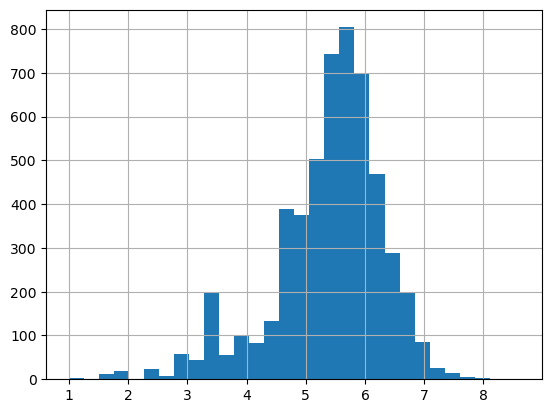

In [ ]:
gene_go_matrix.sum(axis=1).map(np.log2).hist(bins=30)

## Load distance matrixs

In [16]:
Euclidean_Distance = pd.read_csv("../../results/HD_DIT_HAP/21_similarity_analysis_for_terms/euclidean_distance_matrix.csv", index_col=0)
Manhattan_Distance = pd.read_csv("../../results/HD_DIT_HAP/21_similarity_analysis_for_terms/manhattan_distance_matrix.csv", index_col=0)
Cosine_Similarity = pd.read_csv("../../results/HD_DIT_HAP/21_similarity_analysis_for_terms/cosine_similarity_matrix.csv", index_col=0)
Mahalanobis_Distance = pd.read_csv("../../results/HD_DIT_HAP/21_similarity_analysis_for_terms/mahalanobis_distance_matrix.csv", index_col=0)

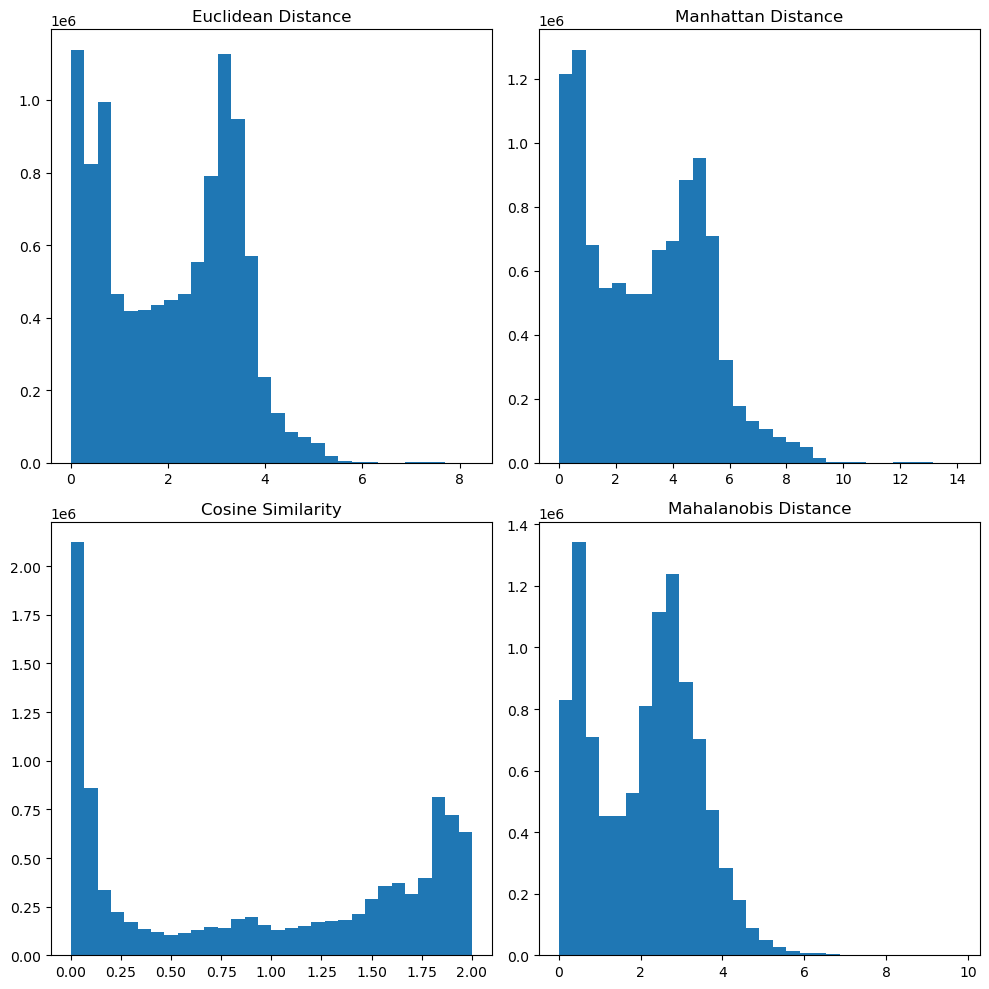

In [29]:
euclidean_values = np.triu(Euclidean_Distance, k=1)
euclidean_values = euclidean_values[euclidean_values!=0]

manhattan_values = np.triu(Manhattan_Distance, k=1)
manhattan_values = manhattan_values[manhattan_values!=0]

cosine_values = np.triu(Cosine_Similarity, k=1)
cosine_values = cosine_values[cosine_values!=0]

mahalanobis_values = np.triu(Mahalanobis_Distance, k=1)
mahalanobis_values = mahalanobis_values[mahalanobis_values!=0]

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].hist(euclidean_values, bins=30)
axs[0, 0].set_title("Euclidean Distance")
axs[0, 1].hist(manhattan_values, bins=30)
axs[0, 1].set_title("Manhattan Distance")
axs[1, 0].hist(cosine_values, bins=30)
axs[1, 0].set_title("Cosine Similarity")
axs[1, 1].hist(mahalanobis_values, bins=30)
axs[1, 1].set_title("Mahalanobis Distance")

plt.tight_layout()
plt.show()
plt.close()

In [62]:
# Calculate distance statistics for each GO term
print("=" * 60)
print("CALCULATING DISTANCE STATISTICS FOR GO TERMS")
print("=" * 60)

# Initialize results dictionary
go_term_stats = {}

# Process each GO term
for go_term in tqdm(all_go_terms, desc="Processing GO terms"):
    if go_term in go2genes:
        # Get genes associated with this GO term
        associated_genes = list(go2genes[go_term])
        
        # Filter genes that exist in our distance matrices
        valid_genes = [gene for gene in associated_genes if gene in Euclidean_Distance.index]
        
        if len(valid_genes) >= 2:  # Need at least 2 genes to calculate distances
            # Initialize stats for this GO term
            go_term_stats[go_term] = {}

            go_name = godag[go_term].name
            go_namespace = godag[go_term].namespace
            go_definition = godag[go_term].defn
            
            # Calculate statistics for each distance metric
            for distance_name, distance_matrix in [
                ('Euclidean', Euclidean_Distance),
                ('Manhattan', Manhattan_Distance),
                ('Cosine', Cosine_Similarity),
                ('Mahalanobis', Mahalanobis_Distance)
            ]:
                # Extract pairwise distances for genes in this GO term
                subset_matrix = distance_matrix.loc[valid_genes, valid_genes]
                
                # Get upper triangle (excluding diagonal) to avoid duplicates
                upper_triangle = np.triu(subset_matrix.values, k=1)
                distances = upper_triangle[upper_triangle != 0]
                
                if len(distances) > 0:
                    # Calculate statistics
                    go_term_stats[go_term][distance_name] = {
                        'GO_name': go_name,
                        'GO_namespace': go_namespace,
                        'GO_definition': go_definition,
                        'Genes': ','.join(associated_genes),
                        'Covered_Genes': ','.join(valid_genes),
                        'n_genes': len(associated_genes),
                        'n_covered_genes': len(valid_genes),
                        'coverage': len(valid_genes) / len(associated_genes),
                        'distances': ','.join(map(str, distances)),
                        'mean': np.mean(distances),
                        'median': np.median(distances),
                        'std': np.std(distances),
                        'min': np.min(distances),
                        'max': np.max(distances),
                        'q25': np.percentile(distances, 25),
                        'q75': np.percentile(distances, 75),
                        'n_pairs': len(distances)
                    }

# Convert to DataFrame for easier analysis
stats_data = []
for go_term, metrics in go_term_stats.items():
    for metric_name, stats in metrics.items():
        row = {'GO_term': go_term, 'distance_metric': metric_name}
        row.update(stats)
        stats_data.append(row)

go_distance_stats_df = pd.DataFrame(stats_data)

print(f"Processed {len(go_term_stats)} GO terms with valid gene associations")
print(f"Created statistics dataframe with shape: {go_distance_stats_df.shape}")


CALCULATING DISTANCE STATISTICS FOR GO TERMS


Processing GO terms: 100%|██████████| 7498/7498 [05:49<00:00, 21.45it/s]  


Processed 5323 GO terms with valid gene associations
Created statistics dataframe with shape: (21284, 19)


In [63]:
go_distance_stats_df.to_csv("../../results/HD_DIT_HAP/21_similarity_analysis_for_terms/go_distance_stats_df.csv", index=False, float_format="%.4f")

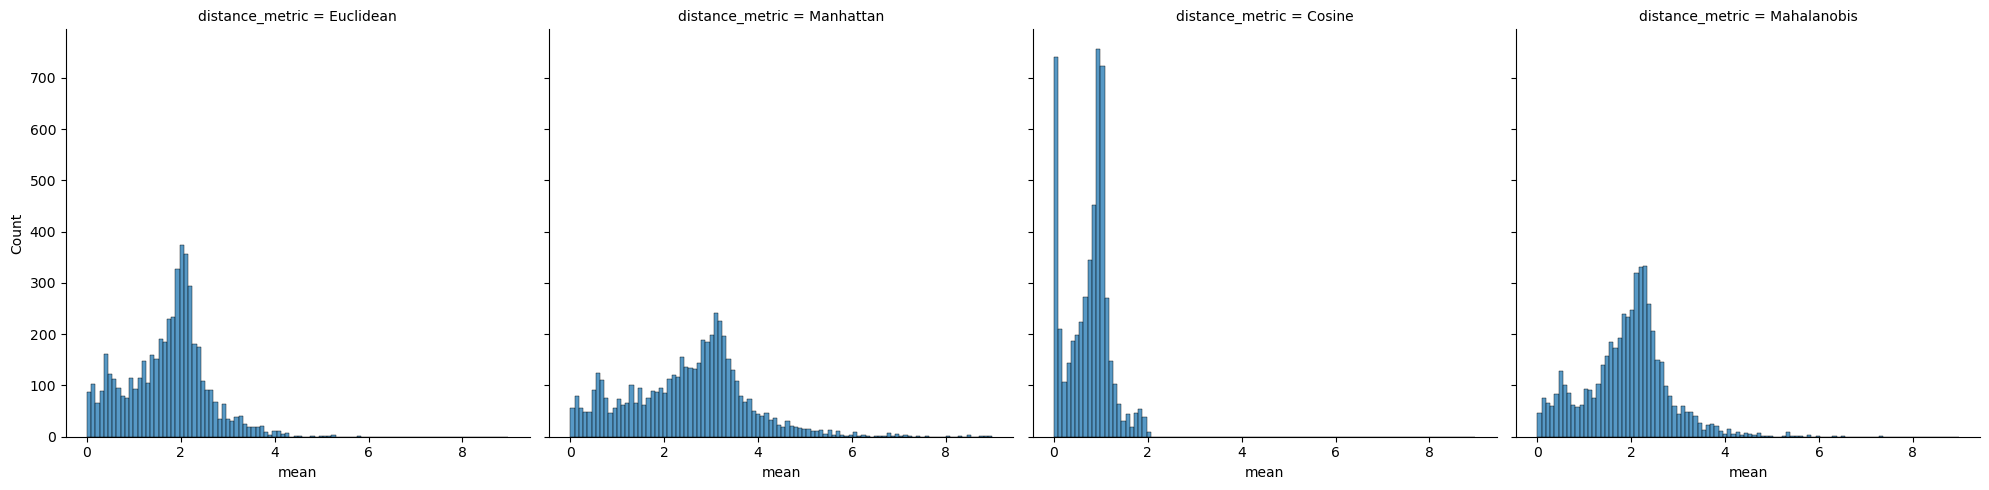

In [52]:
sns.displot(go_distance_stats_df.query("n_genes < 300"), x="mean", bins=100, col="distance_metric")
plt.show()
plt.close()

In [64]:
go_distance_stats_df.query("n_genes < 300 and distance_metric == 'Mahalanobis' and mean < 1").to_excel(output_dir/"GO_namespace_for_terms_with_low_Mahalanobis_distance.xlsx", index=False)

In [66]:
high_similarity_terms = go_distance_stats_df.query("n_genes < 300 and distance_metric == 'Mahalanobis' and mean < 1")["GO_term"].tolist()

## Load fitting results

In [59]:
print("=" * 60)
print("CALCULATING CURVE FEATURES FOR GO TERMS")
print("=" * 60)

# Initialize results dictionary
go_term_curve_features = {}

# Process each GO term
for go_term in tqdm(all_go_terms, desc="Processing GO terms"):
    if go_term in go2genes:
        # Get genes associated with this GO term
        associated_genes = list(go2genes[go_term])
        
        # Filter genes that exist in our distance matrices
        valid_genes = [gene for gene in associated_genes if gene in Euclidean_Distance.index]
        
        if len(valid_genes) >= 2:  # Need at least 2 genes to calculate distances
            # Initialize stats for this GO term
            go_term_curve_features[go_term] = {}

            go_name = godag[go_term].name
            go_namespace = godag[go_term].namespace
            go_definition = godag[go_term].defn
            
            # Calculate statistics for each distance metric
            for feature_name in ["A", "um", "lam"]:
                # Extract pairwise distances for genes in this GO term
                subset_features = gene_data.loc[valid_genes, feature_name].values
                
                if len(subset_features) > 0:
                    # Calculate statistics
                    go_term_curve_features[go_term][feature_name] = {
                        'GO_name': go_name,
                        'GO_namespace': go_namespace,
                        'GO_definition': go_definition,
                        'Genes': ','.join(associated_genes),
                        'Covered_Genes': ','.join(valid_genes),
                        'n_genes': len(associated_genes),
                        'n_covered_genes': len(valid_genes),
                        'coverage': len(valid_genes) / len(associated_genes),
                        'features': ','.join(map(str, subset_features)),
                        'mean': np.mean(subset_features),
                        'median': np.median(subset_features),
                        'std': np.std(subset_features),
                        'min': np.min(subset_features),
                        'max': np.max(subset_features),
                        'q25': np.percentile(subset_features, 25),
                        'q75': np.percentile(subset_features, 75),
                        'n_pairs': len(subset_features)
                    }

# Convert to DataFrame for easier analysis
stats_data = []
for go_term, features in go_term_curve_features.items():
    for feature_name, stats in features.items():
        row = {'GO_term': go_term, 'feature_name': feature_name}
        row.update(stats)
        stats_data.append(row)

go_curve_features_df = pd.DataFrame(stats_data)

print(f"Processed {len(go_term_curve_features)} GO terms with valid gene associations")
print(f"Created statistics dataframe with shape: {go_curve_features_df.shape}")


CALCULATING CURVE FEATURES FOR GO TERMS


Processing GO terms: 100%|██████████| 7498/7498 [00:10<00:00, 727.34it/s] 


Processed 5323 GO terms with valid gene associations
Created statistics dataframe with shape: (15969, 19)


In [60]:
go_curve_features_df.to_csv("../../results/HD_DIT_HAP/21_similarity_analysis_for_terms/go_curve_features_df.csv", index=False, float_format="%.4f")

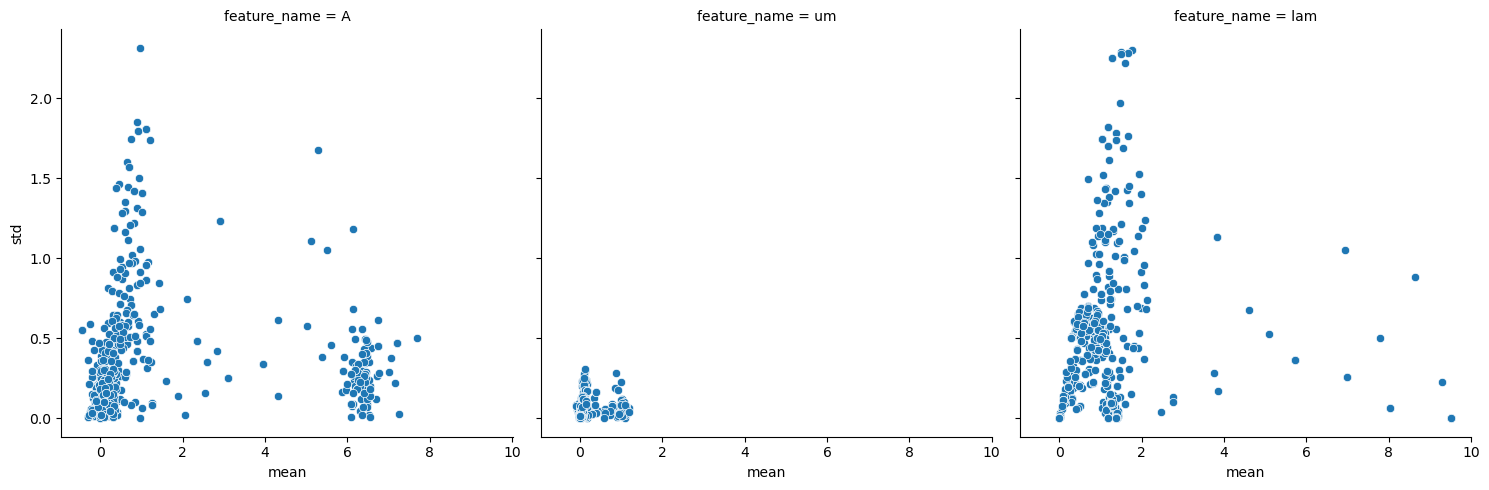

In [ ]:
sns.relplot(go_curve_features_df.query("GO_term in @high_similarity_terms"), x="mean", y="std", col="feature_name")
plt.show()
plt.close()

In [68]:
high_similarity_with_phenotype_terms = go_curve_features_df.query("GO_term in @high_similarity_terms and feature_name == 'A' and mean > 2")["GO_term"].tolist()

In [69]:
go_curve_features_df.query("GO_term in @high_similarity_with_phenotype_terms").to_excel(output_dir/"GO_curve_features_for_terms_with_high_similarity_with_phenotype.xlsx", index=False)